## Load Packages and Dataset

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from ggplot import *
import datetime

In [2]:
train = pd.read_csv('train_c.csv',parse_dates=['timestamp'])
test = pd.read_csv('test_c.csv',parse_dates=['timestamp'])

## Extra Feature Engineering From Kernel

In [5]:
# Add month-year
month_year = (train.timestamp.dt.month + train.timestamp.dt.year * 100)
month_year_cnt_map = month_year.value_counts().to_dict()
train['month_year_cnt'] = month_year.map(month_year_cnt_map)

month_year = (test.timestamp.dt.month + test.timestamp.dt.year * 100)
month_year_cnt_map = month_year.value_counts().to_dict()
test['month_year_cnt'] = month_year.map(month_year_cnt_map)

# Add week-year count
week_year = (train.timestamp.dt.weekofyear + train.timestamp.dt.year * 100)
week_year_cnt_map = week_year.value_counts().to_dict()
train['week_year_cnt'] = week_year.map(week_year_cnt_map)

week_year = (test.timestamp.dt.weekofyear + test.timestamp.dt.year * 100)
week_year_cnt_map = week_year.value_counts().to_dict()
test['week_year_cnt'] = week_year.map(week_year_cnt_map)

# Add month and day-of-week
train['month'] = train.timestamp.dt.month
train['dow'] = train.timestamp.dt.dayofweek

test['month'] = test.timestamp.dt.month
test['dow'] = test.timestamp.dt.dayofweek

# Other feature engineering
train['rel_floor'] = train['floor'] / train['max_floor'].astype(float)
train['rel_kitch_sq'] = train['kitch_sq'] / train['full_sq'].astype(float)

test['rel_floor'] = test['floor'] / test['max_floor'].astype(float)
test['rel_kitch_sq'] = test['kitch_sq'] / test['full_sq'].astype(float)

train['apartment_name']=train.sub_area.astype(str) + train['metro_km_avto'].astype(str)
test['apartment_name']=test.sub_area.astype(str) + train['metro_km_avto'].astype(str)

train['room_size'] = train['life_sq'] / train['num_room'].astype(float)
test['room_size'] = test['life_sq'] / test['num_room'].astype(float)

In [6]:
train['apartment_name'] = pd.factorize(train['apartment_name'],sort=True)[0]
test['apartment_name'] = pd.factorize(test['apartment_name'],sort=True)[0]

## Level 1: Base model fitting

In [16]:
col = list(test.columns)[3:]

In [17]:
train_new = train[col]
test_new = test[col]
label = train['price_doc']*0.96+10

### xgboost

In [19]:
import xgboost as xgb

In [20]:
dtrain1 = xgb.DMatrix(train_new,label)
dtest1 = xgb.DMatrix(test_new)

In [25]:
params_xgb = {
    'eta': 0.05, ## Try 0.01,3,5
    'max_depth': 4,## Try 4,5,6
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}

[0]	train-rmse:7.89928e+06+47065.9	test-rmse:7.90123e+06+96323.2
[50]	train-rmse:2.89864e+06+32631.7	test-rmse:3.14053e+06+69847
[100]	train-rmse:2.54898e+06+34093	test-rmse:2.91099e+06+65596
[150]	train-rmse:2.39865e+06+27165	test-rmse:2.84661e+06+68160.9
[200]	train-rmse:2.30536e+06+21736	test-rmse:2.81109e+06+71853
[250]	train-rmse:2.2341e+06+21903.8	test-rmse:2.7889e+06+70608.5
[300]	train-rmse:2.17511e+06+24204.7	test-rmse:2.77318e+06+69375.5
[350]	train-rmse:2.12693e+06+23998.6	test-rmse:2.76103e+06+68365
[400]	train-rmse:2.08467e+06+24384.2	test-rmse:2.75347e+06+65949.2
[450]	train-rmse:2.04305e+06+23567.4	test-rmse:2.74554e+06+64378.8
[500]	train-rmse:2.00421e+06+22803.5	test-rmse:2.73772e+06+65773.3
[550]	train-rmse:1.96676e+06+22002.6	test-rmse:2.73385e+06+66298.2
[600]	train-rmse:1.932e+06+22155	test-rmse:2.7303e+06+65578.7
[650]	train-rmse:1.89999e+06+20544.6	test-rmse:2.7273e+06+65911.3
[700]	train-rmse:1.86974e+06+20450.6	test-rmse:2.72429e+06+65032.4
Performance does not

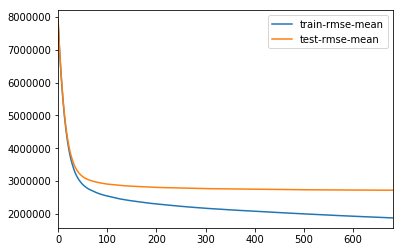

In [26]:
xgb_cvalid = xgb.cv(params_xgb, dtrain1, num_boost_round=1000, early_stopping_rounds=20,
    verbose_eval=50, show_stdv=True,seed=42)
xgb_cvalid[['train-rmse-mean', 'test-rmse-mean']].plot()
print('Performance does not improve from '+str(len(xgb_cvalid))+' rounds')

In [ ]:
#params_xgb = {
 #   'eta': 0.05, ## Try 0.01,3,5
  #  'max_depth': 5,## Try 4,5,6
   # 'subsample': 0.7,
    #'colsample_bytree': 0.7,
    #'objective': 'reg:linear',
    #'eval_metric': 'rmse',
     #'silent': 1
#}
#[0]	train-rmse:7.89125e+06+47275.3	test-rmse:7.89619e+06+96049.9
#[50]	train-rmse:2.66124e+06+22045.6	test-rmse:3.03451e+06+64959.7
#[100]	train-rmse:2.30641e+06+29802.6	test-rmse:2.8353e+06+58962.5
#[150]	train-rmse:2.1698e+06+27120.3	test-rmse:2.78755e+06+61657.4
#[200]	train-rmse:2.07804e+06+24472	test-rmse:2.76043e+06+64101.7
#[250]	train-rmse:2.00356e+06+21581.1	test-rmse:2.7421e+06+64511.8
#[300]	train-rmse:1.93493e+06+23984.5	test-rmse:2.73101e+06+64473.7
#[350]	train-rmse:1.87679e+06+21164.2	test-rmse:2.72119e+06+65093.2
#[400]	train-rmse:1.82286e+06+19606.7	test-rmse:2.71599e+06+64031.6
#Performance does not improve from 421 rounds

#params_xgb = {
 #   'eta': 0.05, ## Try 0.01,3,5
  #  'max_depth': 6,## Try 4,5,6
   # 'subsample': 0.7,
    #'colsample_bytree': 0.7,
    #'objective': 'reg:linear',
    #'eval_metric': 'rmse',
    #'silent': 1
#}

#[0]	train-rmse:7.88544e+06+46620.4	test-rmse:7.89448e+06+96002.4
#[50]	train-rmse:2.46276e+06+6222.96	test-rmse:2.97979e+06+67623.3
#[100]	train-rmse:2.10138e+06+20908.6	test-rmse:2.79651e+06+60589
#[150]	train-rmse:1.95701e+06+18164.9	test-rmse:2.75416e+06+61128.2
#[200]	train-rmse:1.85513e+06+21631.1	test-rmse:2.73254e+06+60260.4
#[250]	train-rmse:1.76935e+06+24714.9	test-rmse:2.72129e+06+58609.5
#[300]	train-rmse:1.688e+06+22948.4	test-rmse:2.71327e+06+58349.4
#[350]	train-rmse:1.62268e+06+21844	test-rmse:2.70891e+06+57253.3
#Performance does not improve from 344 rounds

#params_xgb = {
 #   'eta': 0.05, ## Try 0.01,3,5
 #   'max_depth': 4,## Try 4,5,6
 #   'subsample': 0.7,
 #   'colsample_bytree': 0.7,
 #   'objective': 'reg:linear',
 #   'eval_metric': 'rmse',
 #   'silent': 1
#}

#[0]	train-rmse:7.89928e+06+47065.9	test-rmse:7.90123e+06+96323.2
#[50]	train-rmse:2.89864e+06+32631.7	test-rmse:3.14053e+06+69847
#[100]	train-rmse:2.54898e+06+34093	test-rmse:2.91099e+06+65596
#[150]	train-rmse:2.39865e+06+27165	test-rmse:2.84661e+06+68160.9
#[200]	train-rmse:2.30536e+06+21736	test-rmse:2.81109e+06+71853
#[250]	train-rmse:2.2341e+06+21903.8	test-rmse:2.7889e+06+70608.5
#[300]	train-rmse:2.17511e+06+24204.7	test-rmse:2.77318e+06+69375.5
#[350]	train-rmse:2.12693e+06+23998.6	test-rmse:2.76103e+06+68365
#[400]	train-rmse:2.08467e+06+24384.2	test-rmse:2.75347e+06+65949.2
#[450]	train-rmse:2.04305e+06+23567.4	test-rmse:2.74554e+06+64378.8
#[500]	train-rmse:2.00421e+06+22803.5	test-rmse:2.73772e+06+65773.3
#[550]	train-rmse:1.96676e+06+22002.6	test-rmse:2.73385e+06+66298.2
#[600]	train-rmse:1.932e+06+22155	test-rmse:2.7303e+06+65578.7
#[650]	train-rmse:1.89999e+06+20544.6	test-rmse:2.7273e+06+65911.3
#[700]	train-rmse:1.86974e+06+20450.6	test-rmse:2.72429e+06+65032.4
#Performance does not improve from 682 rounds

In [34]:
params_xgb = {
    'eta': 0.05, ## Try 0.01,3,5
    'max_depth': 5,## Try 4,5,6
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}

In [35]:
xgb_model = xgb.train(params_xgb,dtrain1,num_boost_round=421)

In [36]:
xgb_feature = xgb_model.predict(dtrain1)
xgb_predict = xgb_model.predict(dtest1)

### Random Forest

In [37]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as MSE

In [46]:
train_new = train_new.replace([np.inf, -np.inf], np.nan)
test_new = test_new.replace([np.inf, -np.inf], np.nan)
train_new = train_new.fillna(-999)
test_new = test_new.fillna(-999)

In [47]:
training = train_new.iloc[:round(len(train_new)*0.8),]
testing = train_new.iloc[round(len(train_new)*0.8):,]

In [48]:
label_train = label[:round(len(train_new)*0.8)]
label_test =  label[round(len(train_new)*0.8):]

In [64]:
rf = RandomForestRegressor(n_estimators= 100,criterion='mse',max_features= 'auto',random_state=42,n_jobs=-1,min_samples_leaf=8)
rf.fit(training,label_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=8,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=-1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

In [65]:
intrain_predict = rf.predict(training)
outtrain_predict = rf.predict(testing)
intrain_RMSE = MSE(intrain_predict,label_train)**0.5
outtrain_RMSE = MSE(outtrain_predict,label_test)**0.5
print('%.2e' %intrain_RMSE)
print('%.2e' %outtrain_RMSE)

2.03e+06
3.11e+06


In [ ]:
#RandomForestRegressor(n_estimators= 500,criterion='rmse',max_features= 'auto',max_depth=5,random_state=42,n_jobs=-1)
#2.95e+06
#3.54e+06
#rf = RandomForestRegressor(n_estimators= 500,criterion='mse',max_features= 'auto',max_depth=5,random_state=42,n_jobs=-1)
#2.99e+06
#3.59e+06
#rf = RandomForestRegressor(n_estimators= 500,criterion='mse', min_samples_leaf = 8,max_features= 20 ,max_depth=5,random_state=42,n_jobs=-1)
#3.36e+06
#3.99e+06
#rf = RandomForestRegressor(n_estimators= 500,criterion='mse', min_samples_leaf = 8,max_features= 20,random_state=42,n_jobs=-1)
#2.41e+06
#3.40e+06
#rf = RandomForestRegressor(n_estimators= 100,criterion='mse',max_features= 'auto',random_state=42,n_jobs=-1)
#1.07e+06
#3.08e+06
#rf = RandomForestRegressor(n_estimators= 100,criterion='mse',max_features= 'auto',random_state=42,n_jobs=-1,min_samples_leaf=8)
#2.03e+06
#3.11e+06


In [67]:
rf = RandomForestRegressor(n_estimators= 100,criterion='mse',max_features= 'auto',random_state=42,n_jobs=-1,min_samples_leaf=8)
rf.fit(train_new,label)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=8,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=-1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

In [70]:
rf_feature = rf.predict(train_new)
rf_predict = rf.predict(test_new)

### Gradient Boosting

In [73]:
from sklearn.ensemble import GradientBoostingRegressor

In [78]:
gbr = GradientBoostingRegressor(learning_rate=0.05,n_estimators=500,max_depth=4,max_features = 0.7,subsample = 0.7,random_state=42)
gbr.fit(training,label_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='ls', max_depth=4, max_features=0.7,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=500,
             presort='auto', random_state=42, subsample=0.7, verbose=0,
             warm_start=False)

In [79]:
intrain_predict = gbr.predict(training)
outtrain_predict = gbr.predict(testing)
intrain_RMSE = MSE(intrain_predict,label_train)**0.5
outtrain_RMSE = MSE(outtrain_predict,label_test)**0.5
print('%.2e' %intrain_RMSE)
print('%.2e' %outtrain_RMSE)

2.05e+06
2.87e+06


In [ ]:
#gbr = GradientBoostingRegressor(learning_rate=0.05,n_estimators=800,max_depth=5,max_features = 0.7,subsample = 0.7,random_state=42)
#1.60e+06
#2.82e+06
#gbr = GradientBoostingRegressor(learning_rate=0.05,n_estimators=800,max_depth=4,max_features = 0.7,subsample = 0.7,random_state=42)
#1.89e+06
#2.85e+06
#gbr = GradientBoostingRegressor(learning_rate=0.05,n_estimators=500,max_depth=4,max_features = 0.7,subsample = 0.7,random_state=42)
#2.05e+06
#2.87e+06

In [80]:
gbr = GradientBoostingRegressor(learning_rate=0.05,n_estimators=800,max_depth=4,max_features = 0.7,subsample = 0.7,random_state=42)

In [81]:
gbr.fit(train_new,label)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='ls', max_depth=4, max_features=0.7,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=800,
             presort='auto', random_state=42, subsample=0.7, verbose=0,
             warm_start=False)

In [82]:
GBM_feature = gbr.predict(train_new)
GBM_predict = gbr.predict(test_new)

## Stack results of three models by XGBoost

In [91]:
stack_features = pd.DataFrame({'xgb':xgb_feature,'rf':rf_feature,'gbm':GBM_feature,'full_sq':train['full_sq']})
stact_predict = pd.DataFrame({'xgb':xgb_predict,'rf':rf_predict,'gbm':GBM_predict,'full_sq':test['full_sq']})

In [92]:
stack_features.to_csv('stack_features.csv',index=False)
stact_predict.to_csv('stack_predictors.csv',index=False)

In [95]:
dtrain_stack = xgb.DMatrix(stack_features,label)
dtest_stack = xgb.DMatrix(stact_predict)

In [105]:
params_stack = {
    'eta': 0.05, ## Try 0.01,3,5
    'max_depth': 5,## Try 4,5,6
    'subsample': 0.5,
    'colsample_bytree': 1,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}

[0]	train-rmse:7.8428e+06+45607.1	test-rmse:7.84327e+06+91066.5
[50]	train-rmse:1.53112e+06+17609.6	test-rmse:1.6033e+06+48421.5
[100]	train-rmse:1.33099e+06+15513.5	test-rmse:1.44777e+06+34836.1
[150]	train-rmse:1.29285e+06+16634	test-rmse:1.43664e+06+30593.1
[200]	train-rmse:1.26334e+06+15215.9	test-rmse:1.43518e+06+29500.7
Performance does not improve from 228 rounds


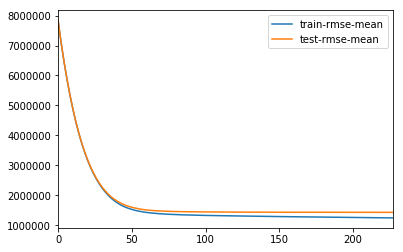

In [106]:
xgb_cvalid = xgb.cv(params_stack, dtrain_stack, num_boost_round=1000, early_stopping_rounds=20,
    verbose_eval=50, show_stdv=True,seed=42)
xgb_cvalid[['train-rmse-mean', 'test-rmse-mean']].plot()
print('Performance does not improve from '+str(len(xgb_cvalid))+' rounds')

In [ ]:
#[500]	train-rmse:1.30227e+06+9897.72	test-rmse:1.44622e+06+28288
#Performance does not improve from 483 rounds

In [107]:
stack_model = xgb.train(params_stack,dtrain_stack,num_boost_round=len(xgb_cvalid))

In [108]:
Final_pred = stack_model.predict(dtest_stack)

In [109]:
Final_pred

array([ 5228931. ,  8544244. ,  5826495. , ...,  2438545. ,  4443043.5,
        8203061.5], dtype=float32)

In [168]:
## Put them together
sub = pd.DataFrame({'id':test['id'],'price_doc':Final_pred})
sub.to_csv('Stacking_Add_Full_Sq_at_Level_2.csv',index=False)